<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c02_exercise_flowers_with_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c02_exercise_flowers_with_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Flowers with transfer learning

# Imports


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Get the Flowers Dataset

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) you will see that the name of the Flowers dataset is `tf_flowers`. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use `tfds.splits` to split this training set into to a `training_set` and a `validation_set`. Do a `[70, 30]` split such that 70 corresponds to the `training_set` and 30 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.


In [4]:
(train_examples, validation_examples), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'], # from 0 to 70 = train, 70% to 100% validation
)

# Print Information about the Flowers Dataset

Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets. 

In [5]:
num_validation_examples = len(validation_examples)
num_training_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 3670
Total Number of Validation Images: 1101 



In [6]:
for i, example in enumerate(train_examples.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches

In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an `image` and a `label` as arguments and should return the new `image` and corresponding `label`. Then create training and validation batches of size `32`.

In [31]:
IMAGE_RES = 224
def format_image(image, label):
  image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_training_examples//4).map(format_image)\
.batch(BATCH_SIZE)\
.prefetch(1)
#validation does not require shuffling
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Create a Feature Extractor


In [18]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
#import mobileNet
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))
feature_extractor.trainable = False

In [24]:
model1 = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(5,activation="softmax")
])
#
model1.summary()
model1.compile(optimizer="adam",
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
EPOCHS = 10
history1 = model1.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_9 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


81/81 [==============================] - 7s 55ms/step - loss: 0.7946 - accuracy: 0.7057 - val_loss: 0.4413 - val_accuracy: 0.8547
Epoch 2/10
81/81 [==============================] - 4s 50ms/step - loss: 0.3825 - accuracy: 0.8712 - val_loss: 0.3613 - val_accuracy: 0.8765
Epoch 3/10
81/81 [==============================] - 6s 69ms/step - loss: 0.2982 - accuracy: 0.9042 - val_loss: 0.3267 - val_accuracy: 0.8865
Epoch 4/10
81/81 [==============================] - 4s 51ms/step - loss: 0.2532 - accuracy: 0.9206 - val_loss: 0.3123 - val_accuracy: 0.8874
Epoch 5/10
81/81 [==============================] - 4s 50ms/step - loss: 0.2160 - accuracy: 0.9377 - val_loss: 0.2913 - val_accuracy: 0.9001
Epoch 6/10
81/81 [==============================] - 4s 52ms/step - loss: 0.1886 - accuracy: 0.9498 - val_loss: 0.2893 - val_accuracy: 0.8983
Epoch 7/10
81/81 [==============================] - 4s 48ms/step - loss: 0.1689 - accuracy: 0.9572 - val_loss: 0.2827 - val_accuracy: 0.9037
Epoch 8/10
81/81 [======

Previously, we got acc\~85% and val_acc\~78% for 30 epochs. MobileNetV2 from experts is getting 97% and 91% with 1/3 of epochs, respectively.

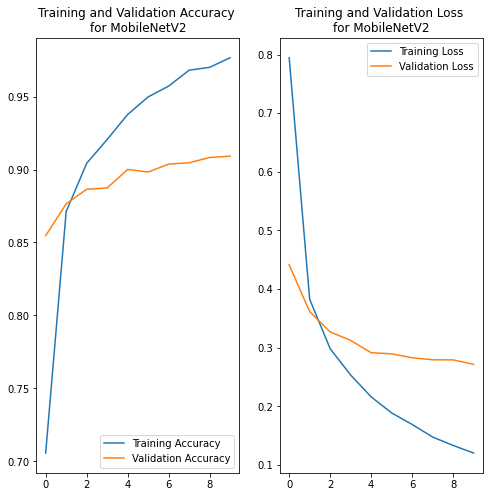

In [25]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy \nfor MobileNetV2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss \nfor MobileNetV2')
plt.show()

# Check Predictions

In [26]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

### Image Batch and Make Predictions

1/1 [==============================] - 0s 484ms/step
[[1.4564101e-01 1.3024803e-01 5.9919703e-01 5.7380978e-02 6.7532972e-02]
 [4.2277293e-06 1.3609191e-04 8.9852199e-02 3.2928230e-03 9.0671462e-01]
 [6.5999589e-04 1.2905982e-03 5.0094251e-02 5.6925696e-08 9.4795507e-01]
 [9.9980313e-01 9.7778509e-05 2.0758178e-05 5.7995756e-05 2.0394764e-05]
 [1.8752235e-06 1.9478097e-05 9.9800509e-01 3.3226438e-06 1.9703293e-03]
 [6.0358725e-02 1.1497309e-01 8.2457602e-01 7.3482603e-05 1.8724890e-05]
 [4.5796207e-04 1.3689939e-05 2.9022747e-03 6.3527943e-05 9.9656254e-01]
 [1.2893085e-01 7.9192389e-03 1.8535414e-01 6.5392351e-01 2.3872217e-02]
 [8.9426607e-08 2.5350894e-07 9.9957031e-01 2.0247725e-07 4.2912742e-04]
 [2.4490347e-02 9.7207582e-01 2.3505623e-03 6.4100832e-04 4.4230075e-04]
 [9.9423522e-01 5.6178141e-03 8.0536956e-05 6.6040746e-05 3.9384813e-07]
 [9.2746401e-03 2.1721481e-03 4.9042620e-02 5.1683973e-04 9.3899381e-01]
 [9.9991775e-01 4.9562477e-05 2.0993912e-06 9.9932513e-06 2.0608979e-05

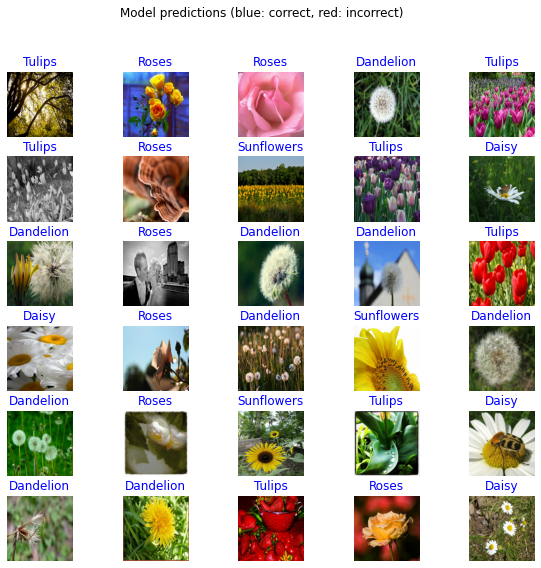

In [27]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()


predicted_batch = model1.predict(image_batch)
print(predicted_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
#obtain index for the max probability of the array
predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = class_names[predicted_ids]
predicted_class_names

print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)
#plot
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")




# MobileNetV2 vs Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [32]:
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image, label

train_batches2 = train_examples.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
#validation does not require shuffling
validation_batches2 = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [36]:
URL2 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor2 = hub.KerasLayer(URL2,
                                    input_shape=(IMAGE_RES, IMAGE_RES,3),
                                    trainable=False)

model2 = tf.keras.Sequential([
    feature_extractor2,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model2.summary()
model2.compile(optimizer="adam",
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
EPOCHS = 10
history2 = model2.fit(train_batches2,
                    epochs=EPOCHS,
                    validation_data=validation_batches2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_10 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


81/81 [==============================] - 46s 487ms/step - loss: 0.7847 - accuracy: 0.7162 - val_loss: 0.4659 - val_accuracy: 0.8601
Epoch 2/10
81/81 [==============================] - 13s 166ms/step - loss: 0.3991 - accuracy: 0.8743 - val_loss: 0.3544 - val_accuracy: 0.8883
Epoch 3/10
81/81 [==============================] - 15s 186ms/step - loss: 0.3114 - accuracy: 0.9039 - val_loss: 0.3282 - val_accuracy: 0.8946
Epoch 4/10
81/81 [==============================] - 15s 184ms/step - loss: 0.2644 - accuracy: 0.9229 - val_loss: 0.2959 - val_accuracy: 0.8983
Epoch 5/10
81/81 [==============================] - 15s 180ms/step - loss: 0.2333 - accuracy: 0.9319 - val_loss: 0.2797 - val_accuracy: 0.9046
Epoch 6/10
81/81 [==============================] - 13s 165ms/step - loss: 0.2035 - accuracy: 0.9416 - val_loss: 0.2779 - val_accuracy: 0.9064
Epoch 7/10
81/81 [==============================] - 14s 167ms/step - loss: 0.1851 - accuracy: 0.9463 - val_loss: 0.2685 - val_accuracy: 0.9010
Epoch 8/10

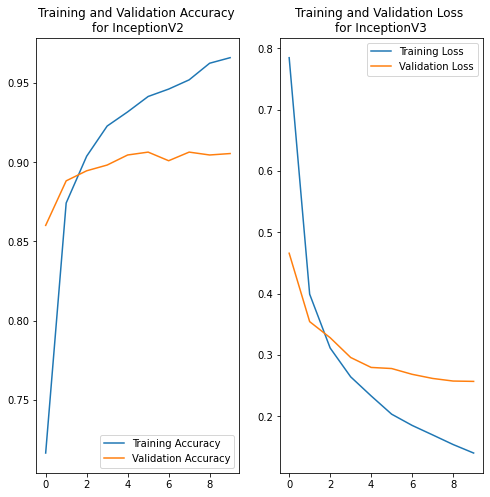

In [38]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy \nfor InceptionV2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss \nfor InceptionV3')
plt.show()

We have got similar performance for MobileNet and inception.